In [1]:
!pip install scikit-learn==1.3.2 lazypredict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 32.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
from joblib import dump
import itertools
import matplotlib.pyplot as plt
import numpy as np
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [5]:
rice_df = pd.read_excel('/content/rice_w2vec_3mer_64_dataset.xlsx')

In [6]:
df_cold = rice_df.query('stress == "-" or stress == "cold"').replace('-', 0).replace('cold', 1)

In [7]:
# Define X and y (target) variables
X = df_cold.drop(['circName','stress','tissue','chr','start','end','strand','start_anno', 'circID',	'gene', 'isoform', 'width', 'detection_score', 'stress_detection_score', 'end_anno', 'antisense', 'algorithm', 'seq', 'exonSeq', 'predAA', 'miRNA','superCircRNARegion'], axis=1)
y = df_cold['stress']

In [8]:
X.head(2)

,wc_3mer_1,wc_3mer_2,wc_3mer_3,wc_3mer_4,wc_3mer_5,wc_3mer_6,wc_3mer_7,wc_3mer_8,wc_3mer_9,wc_3mer_10,...,wc_3mer_55,wc_3mer_56,wc_3mer_57,wc_3mer_58,wc_3mer_59,wc_3mer_60,wc_3mer_61,wc_3mer_62,wc_3mer_63,wc_3mer_64
0,-8.66,-17.17,-20.12,10.61,-0.19,1.57,3.90,7.62,-2.83,13.90,...,-21.98,-12.45,-8.38,-9.52,28.57,7.25,-18.07,-6.67,-3.78,1.30
1,-4.62,-42.06,-73.49,-51.22,83.97,-47.22,-20.22,29.19,-17.14,37.22,...,24.44,-68.49,20.16,14.18,81.44,-4.52,21.87,-10.53,-39.17,63.34


In [9]:
y.value_counts()

,count
stress,
0,50187
1,5724


In [10]:
ros = RandomUnderSampler(sampling_strategy=0.7)

X_res, y_res = ros.fit_resample(X, y)

In [11]:
y_res.value_counts()

,count
stress,
0,8177
1,5724


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=320)

In [13]:
clf = LazyClassifier(predictions=True, random_state=320)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

 97%|█████████▋| 28/29 [02:20<00:03,  3.34s/it]

[LightGBM] [Info] Number of positive: 4589, number of negative: 6531
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 11120, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.412680 -> initscore=-0.352898
[LightGBM] [Info] Start training from score -0.352898


100%|██████████| 29/29 [02:21<00:00,  4.89s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.74,0.73,0.73,0.74,15.10
LGBMClassifier,0.74,0.72,0.72,0.73,1.39
ExtraTreesClassifier,0.73,0.71,0.71,0.73,3.76
XGBClassifier,0.72,0.71,0.71,0.72,2.15
AdaBoostClassifier,0.72,0.70,0.70,0.72,13.16
BaggingClassifier,0.72,0.69,0.69,0.71,18.59
SVC,0.70,0.68,0.68,0.70,10.27
LabelSpreading,0.68,0.68,0.68,0.68,20.10
LabelPropagation,0.68,0.68,0.68,0.68,5.85


In [14]:
from sklearn.ensemble import RandomForestClassifier

modelrf = RandomForestClassifier(random_state=320)
modelrf.fit(X_train, y_train)

y_pred_rf = modelrf.predict(X_test)
report = classification_report(y_test, y_pred_rf)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1646
           1       0.71      0.63      0.67      1135

    accuracy                           0.75      2781
   macro avg       0.74      0.73      0.73      2781
weighted avg       0.74      0.75      0.74      2781



In [15]:
dump(modelrf, 'rf_model_cold_3mer_64.joblib')
print('RF - Cold Model created.')

RF - Cold Model created.


In [16]:
model_lgb = lgb.LGBMClassifier(random_state=320)
model_lgb.fit(X_train, y_train)

y_pred_lgb = model_lgb.predict(X_test)
report = classification_report(y_test, y_pred_lgb)
print(report)

[LightGBM] [Info] Number of positive: 4589, number of negative: 6531
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 11120, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.412680 -> initscore=-0.352898
[LightGBM] [Info] Start training from score -0.352898
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1646
           1       0.68      0.63      0.66      1135

    accuracy                           0.73      2781
   macro avg       0.72      0.71      0.72      2781
weighted avg       0.73      0.73      0.73      2781



In [17]:
dump(model_lgb, 'lgb_model_cold_3mer_64.joblib')
print('LGB - Cold Model created.')

LGB - Cold Model created.


In [19]:
from sklearn.ensemble import ExtraTreesClassifier

modelext = ExtraTreesClassifier(random_state=320)
modelext.fit(X_train, y_train)

y_pred_ext = modelext.predict(X_test)
report = classification_report(y_test, y_pred_ext)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      1646
           1       0.69      0.62      0.65      1135

    accuracy                           0.73      2781
   macro avg       0.72      0.71      0.72      2781
weighted avg       0.73      0.73      0.73      2781



In [20]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
report = classification_report(y_test, y_pred_dummy)
print(report)

              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1646
           1       0.00      0.00      0.00      1135

    accuracy                           0.59      2781
   macro avg       0.30      0.50      0.37      2781
weighted avg       0.35      0.59      0.44      2781



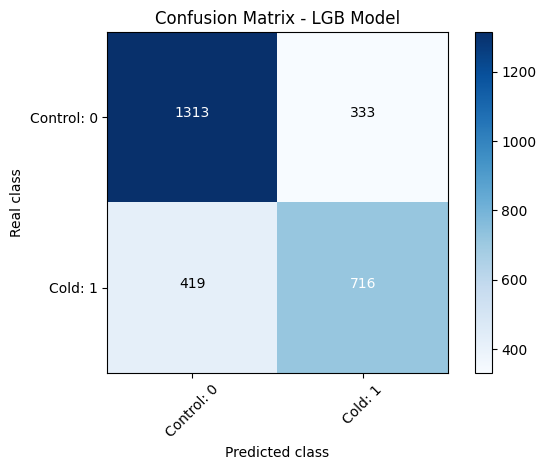

In [21]:
cnf_matrix = confusion_matrix(y_test, y_pred_lgb)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix - LGB Model',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #plt.ylim(0.5, 0.5)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(1.5, -0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.tight_layout()

plot_confusion_matrix(cnf_matrix, classes=['Control: 0', 'Cold: 1'])

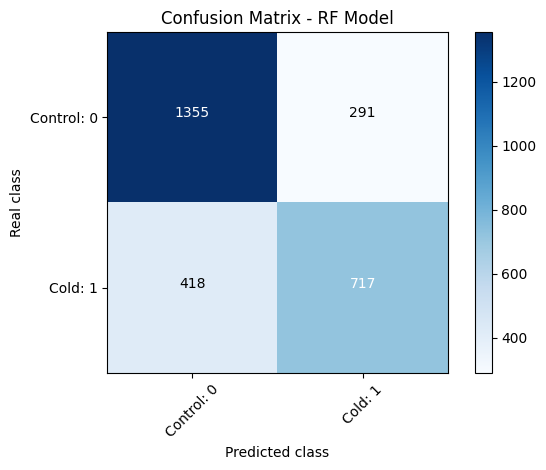

In [22]:
cnf_matrix = confusion_matrix(y_test, y_pred_rf)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix - RF Model',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #plt.ylim(0.5, 0.5)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(1.5, -0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.tight_layout()

plot_confusion_matrix(cnf_matrix, classes=['Control: 0', 'Cold: 1'])

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score
scores = cross_val_score(model_lgb, X_res, y_res, cv=4)
print("Scores:", scores)
print("Median:", scores.mean())

[LightGBM] [Info] Number of positive: 4293, number of negative: 6132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 10425, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411799 -> initscore=-0.356535
[LightGBM] [Info] Start training from score -0.356535
[LightGBM] [Info] Number of positive: 4293, number of negative: 6133
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 10426, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411759 -> initscore=-0.356698
[LightGBM] [Info] Start training from score -0.356698
[LightGBM] [In

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
scores = cross_val_score(modelrf, X_res, y_res, cv=4)
print("Scores:", scores)
print("Median:", scores.mean())

Scores: [0.70224396 0.71625899 0.69870504 0.7257554 ]
Median: 0.7107408457583761


In [25]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
import numpy as np
y_prob = model_lgb.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.1, 0.1)
results = []

for threshold in thresholds:
    y_pred_test = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_test, y_prob)
    accuracy = accuracy_score(y_test, y_pred_test)

    results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Acurácia': accuracy
    })

results_df = pd.DataFrame(results)
print(results_df)

    Threshold  Precision  Recall  F1 Score  AUC  Acurácia
0        0.00       0.41    1.00      0.58 0.79      0.41
1        0.10       0.44    0.98      0.60 0.79      0.47
2        0.20       0.51    0.91      0.66 0.79      0.61
3        0.30       0.58    0.83      0.68 0.79      0.68
4        0.40       0.64    0.75      0.69 0.79      0.72
5        0.50       0.68    0.63      0.66 0.79      0.73
6        0.60       0.74    0.51      0.60 0.79      0.73
7        0.70       0.78    0.36      0.49 0.79      0.70
8        0.80       0.83    0.19      0.31 0.79      0.65
9        0.90       0.84    0.02      0.05 0.79      0.60
10       1.00       0.00    0.00      0.00 0.79      0.59


In [26]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
import numpy as np
y_prob = modelrf.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.1, 0.1)
results = []

for threshold in thresholds:
    y_pred_test = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_test, y_prob)
    accuracy = accuracy_score(y_test, y_pred_test)

    results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Acurácia': accuracy
    })

results_df = pd.DataFrame(results)
print(results_df)


    Threshold  Precision  Recall  F1 Score  AUC  Acurácia
0        0.00       0.41    1.00      0.58 0.79      0.41
1        0.10       0.43    0.99      0.60 0.79      0.45
2        0.20       0.48    0.94      0.63 0.79      0.56
3        0.30       0.55    0.85      0.67 0.79      0.65
4        0.40       0.62    0.77      0.69 0.79      0.72
5        0.50       0.70    0.64      0.67 0.79      0.74
6        0.60       0.77    0.46      0.58 0.79      0.72
7        0.70       0.81    0.28      0.42 0.79      0.68
8        0.80       0.85    0.16      0.26 0.79      0.64
9        0.90       0.86    0.03      0.06 0.79      0.60
10       1.00       0.00    0.00      0.00 0.79      0.59
